In [1]:
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import sklearn

%precision 3

'%.3f'

In [2]:
import requests, zipfile
import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
zip_file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
bank = pd.read_csv("bank-full.csv", sep=';')
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# 問題1

基本統計量の算出

In [5]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


# 問題2

データの'job', 'marital', 'education', 'default', 'housing', 'loan'のそれぞれについて、預金を申し込む人、申し込まない人の人数を算出

In [6]:
labels = ['job', 'marital', 'education', 'default', 'housing', 'loan']
for label in labels:
    print(bank.groupby([label, 'y'])['y'].count().unstack())
    print('')

y                no   yes
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
retired        1748   516
self-employed  1392   187
services       3785   369
student         669   269
technician     6757   840
unemployed     1101   202
unknown         254    34

y            no   yes
marital              
divorced   4585   622
married   24459  2755
single    10878  1912

y             no   yes
education             
primary     6260   591
secondary  20752  2450
tertiary   11305  1996
unknown     1605   252

y           no   yes
default             
no       39159  5237
yes        763    52

y           no   yes
housing             
no       16727  3354
yes      23195  1935

y        no   yes
loan             
no    33162  4805
yes    6760   484



# 問題3

預金を申し込む、申し込まないを目的変数として、予測モデルを構築する。

In [7]:
X = pd.concat([bank.drop(['job', 'marital', 'education', 'default', 'housing',
                          'loan', 'contact', 'month', 'poutcome', 'y'], axis=1),
               pd.get_dummies(bank[['job', 'marital', 'education', 'default', 'housing',
                     'loan', 'contact', 'month', 'poutcome']])],
              axis=1)
y = bank.y.map(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [8]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [9]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'kNN': KNeighborsClassifier(n_jobs=-1),
    'LinearSVC': LinearSVC(),
    'SVC': SVC(),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
}

In [10]:
for model_name, model in models.items():
    model.fit(X_train_std, y_train)
    print('===============================================================')
    print(model.__class__.__name__)
    pred_y = model.predict(X_test_std)
    confusion_m = confusion_matrix(y_test, pred_y)
    print('train:', model.score(X_train_std, y_train))
    print('test:', model.score(X_test_std, y_test))
    print('Confusion matrix:\n{}'.format(confusion_m))
    print('適合率:%.3f' % precision_score(y_true=y_test, y_pred=pred_y))
    print('再現率:%.3f' % recall_score(y_true=y_test, y_pred=pred_y))
    print('F1値:%.3f' % f1_score(y_true=y_test, y_pred=pred_y))

LogisticRegression
train: 0.9041362530413626
test: 0.901043970627267
Confusion matrix:
[[19413   555]
 [ 1682   956]]
適合率:0.633
再現率:0.362
F1値:0.461
DecisionTreeClassifier
train: 0.907100199071002
test: 0.8996284172343626
Confusion matrix:
[[19429   539]
 [ 1730   908]]
適合率:0.628
再現率:0.344
F1値:0.445
KNeighborsClassifier
train: 0.9186905551869056
test: 0.8921967619216137
Confusion matrix:
[[19396   572]
 [ 1865   773]]
適合率:0.575
再現率:0.293
F1値:0.388


C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
train: 0.903251493032515
test: 0.8990975847120234
Confusion matrix:
[[19506   462]
 [ 1819   819]]
適合率:0.639
再現率:0.310
F1値:0.418
SVC
train: 0.923512497235125
test: 0.9009554985402105
Confusion matrix:
[[19444   524]
 [ 1715   923]]
適合率:0.638
再現率:0.350
F1値:0.452
RandomForestClassifier
train: 0.8955540809555408
test: 0.894718216402725
Confusion matrix:
[[19859   109]
 [ 2271   367]]
適合率:0.771
再現率:0.139
F1値:0.236


* 適合率
  * RandomForestが高い（再現率は低い）
* 再現率
  * LogisticRegressionが高い
* F1値
  * LogisticRegression, DecisionTree, SVCが高い

In [11]:
X = pd.concat([bank.drop(['job', 'marital', 'education', 'default', 'housing',
                          'loan', 'contact', 'month', 'poutcome', 'y'], axis=1),
               pd.get_dummies(bank[['job', 'marital', 'education', 'default', 'housing',
                     'loan', 'contact', 'month', 'poutcome']])],
              axis=1)
y = bank.y.map(lambda x: 1 if x == 'yes' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [12]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [13]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'SVC': SVC(probability=True)
}

train: 0.9041362530413626
test: 0.901043970627267
train: 0.907100199071002
test: 0.8996284172343626
train: 0.923512497235125
test: 0.9009554985402105


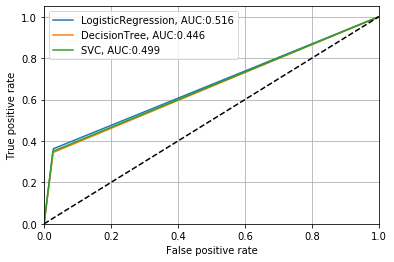

In [14]:
for model_name, model in models.items():
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    print('train:', model.score(X_train_std, y_train))
    print('test:', model.score(X_test_std, y_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=model_name+', AUC:' + str(round(auc, 3)))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="best")
plt.grid(True)

# 以下、↓解答のコピペ

In [15]:
banking_c_data = pd.read_csv("bank-full.csv", sep=';')
banking_c_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [16]:
banking_c_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [17]:
col_name_list = ['job', 'marital', 'education', 'default', 'housing', 'loan']
for col_name in col_name_list:
    print('----------------------' + col_name + '----------------------')
    print(banking_c_data.groupby([col_name, 'y'])['y'].count().unstack()
          / banking_c_data.groupby(['y'])['y'].count()*100)

----------------------job----------------------
y                     no        yes
job                                
admin.         11.372176  11.930422
blue-collar    22.604078  13.386273
entrepreneur    3.416662   2.325581
housemaid       2.833024   2.060881
management     20.432343  24.598223
retired         4.378538   9.756098
self-employed   3.486799   3.535640
services        9.480988   6.976744
student         1.675768   5.086028
technician     16.925505  15.882019
unemployed      2.757878   3.819247
unknown         0.636241   0.642844
----------------------marital----------------------
y                no        yes
marital                       
divorced  11.484896  11.760257
married   61.266971  52.089242
single    27.248134  36.150501
----------------------education----------------------
y                 no        yes
education                      
primary    15.680577  11.174135
secondary  51.981364  46.322556
tertiary   28.317720  37.738703
unknown     4.020340   4.76

In [18]:
banking_c_data_dummy = pd.get_dummies(banking_c_data[['job', 'marital', 'education',
                                                      'default', 'housing', 'loan']])
banking_c_data_dummy.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,1,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0


In [19]:
banking_c_data_dummy['flg'] = banking_c_data['y'].map(lambda x: 1 if x == 'yes' else 0)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

X = pd.concat([banking_c_data_dummy.drop('flg', axis=1),
               banking_c_data[['age', 'balance', 'campaign']]],
              axis=1)
Y = banking_c_data_dummy['flg']

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=0)

for model in [LogisticRegression(),
              DecisionTreeClassifier(),
              KNeighborsClassifier(n_neighbors=5),
              RandomForestClassifier()]:
    fit_model = model.fit(X_train, y_train)
    pred_y = fit_model.predict(X_test)
    confusion_m = confusion_matrix(y_test, pred_y)
    
    print('train:', fit_model.__class__.__name__, fit_model.score(X_train, y_train))
    print('test:', fit_model.__class__.__name__, fit_model.score(X_test, y_test))
    print('Confusion matrix:\n{}'.format(confusion_m))
    print('適合率:%.3f' % precision_score(y_true=y_test, y_pred=pred_y))
    print('再現率:%.3f' % recall_score(y_true=y_test, y_pred=pred_y))
    print('F1値:%.3f' % f1_score(y_true=y_test, y_pred=pred_y))


C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train: LogisticRegression 0.8828595021823759
test: LogisticRegression 0.8830399009112625
Confusion matrix:
[[9980    1]
 [1321    1]]
適合率:0.500
再現率:0.001
F1値:0.002
train: DecisionTreeClassifier 0.9943966025716645
test: DecisionTreeClassifier 0.8143855613553924
Confusion matrix:
[[8827 1154]
 [ 944  378]]
適合率:0.247
再現率:0.286
F1値:0.265
train: KNeighborsClassifier 0.8984015571546538
test: KNeighborsClassifier 0.868530478633991
Confusion matrix:
[[9681  300]
 [1186  136]]
適合率:0.312
再現率:0.103
F1値:0.155
train: RandomForestClassifier 0.9943081278754277
test: RandomForestClassifier 0.8772892152525879
Confusion matrix:
[[9661  320]
 [1067  255]]
適合率:0.443
再現率:0.193
F1値:0.269


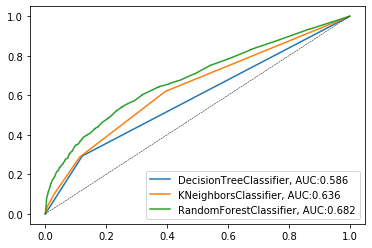

In [21]:
for model in [DecisionTreeClassifier(),
              KNeighborsClassifier(n_neighbors=5),
              RandomForestClassifier()]:
    fit_model = model.fit(X_train, y_train)
    method = fit_model.__class__.__name__
    fpr, tpr, thresholds = roc_curve(y_test, fit_model.predict_proba(X_test)[:, 1])
    auc = roc_auc_score(y_test, fit_model.predict_proba(X_test)[:, 1])
    
    plt.plot(fpr, tpr, label=method+', AUC:' + str(round(auc, 3)))
    plt.legend(loc=4)

plt.plot([0, 1], [0, 1], color='black', lw=0.5, linestyle='--')